In [1]:
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lume_model.torch import LUMEModule

from utils import NegativeTransverseBeamSize
from utils import load_surrogate, load_corr_model, create_vocs, calc_corr, calc_mae

In [2]:
# load surrogate model and define objective
surrogate = load_surrogate("configs/lcls_variables.yml", "configs/normalization.json", "torch_model.pt")
surrogate._model.eval()
surrogate._model.requires_grad_(False)

objective_name = "negative_sigma_xy"
vocs = create_vocs(surrogate, objective_name)

input_names = list(surrogate.input_variables.keys())
surrogate_module = LUMEModule(surrogate, input_names, ["sigma_x", "sigma_y"])
surrogate_module.eval()
surrogate_module.requires_grad_(False)

Objective = NegativeTransverseBeamSize
ground_truth = Objective(surrogate_module)

# Xopt evaluator function
def evaluate(input_dict):
    model_result = surrogate.evaluate(input_dict)
    obj_kwargs = {key:model_result[key] for key in surrogate_module.output_order}
    obj_value = Objective.function(**obj_kwargs).detach().item()
    return {objective_name: obj_value}

In [3]:
# load correlated models
n_epochs = 25
corr_modules, corr_objs = [], []
for n_epoch in range(1, n_epochs + 1):
    corr_model = load_corr_model("configs/lcls_variables.yml", "corr_models/x_transformer.pt", 
                                 "corr_models/y_transformer.pt", "corr_models/{:d}ep.pt".format(n_epoch))
    corr_model._model.eval()
    corr_model._model.requires_grad_(False)

    corr_module = LUMEModule(corr_model, input_names, ["sigma_x", "sigma_y"])
    corr_module.eval()
    corr_module.requires_grad_(False)

    corr_modules.append(corr_module)
    corr_objs.append(Objective(corr_module))

# Correlations and MAEs

In [4]:
path = "./corr_models/"
rng_seed = 0
n_samples = 10000
cutoff_value = None

# uniform samples
inputs_test = [vocs.random_inputs() for _ in range(10000)]
outputs_test = [evaluate(input_dict)[objective_name] for input_dict in inputs_test]
data_test = pd.DataFrame(inputs_test)
data_test[objective_name] = outputs_test
x_test = torch.tensor(data_test[input_names].values)
x_test_variables = torch.tensor(data_test[vocs.variable_names].values)
with torch.no_grad():
    y_test = torch.tensor(data_test[vocs.objective_names].values).squeeze()
    
# MAE for best constant
y_const = torch.mean(y_test) * torch.ones_like(y_test)
mae_const = calc_mae(y_test, y_const)

# calculate correlations and MAE for all models
correlations, maes = [], []
for i in range(n_epochs):
    with torch.no_grad():
        y_corr = corr_objs[i](x_test).detach()
        correlations.append(calc_corr(y_test, y_corr, cutoff_value))
        maes.append(calc_mae(y_test, y_corr))
# torch.save(torch.tensor(correlations), path + "correlations.pt")
# torch.save(torch.tensor(maes), path + "maes.pt")

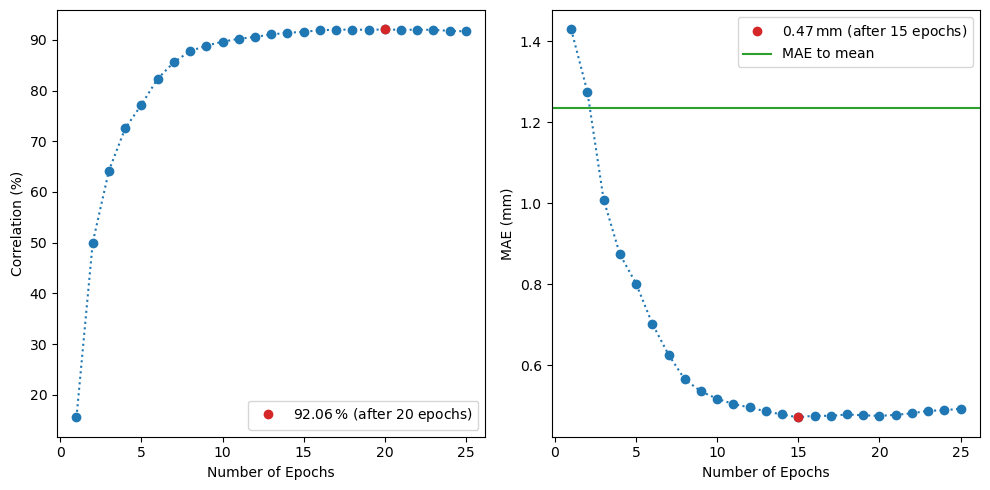

In [5]:
# find best models
idx_best_corr = np.argmax(correlations)
idx_best_mae = np.argmin(maes)

# plot correlations and MAEs
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].plot(torch.arange(n_epochs) + 1, 100 * np.array(correlations), "C0o:")
ax[0].plot(idx_best_corr + 1, 100 * correlations[idx_best_corr], "C3o", 
           label="{:.2f}$\,$% (after {:d} epochs)".format(100 * correlations[idx_best_corr], idx_best_corr + 1))
ax[0].set_xlabel("Number of Epochs")
ax[0].set_ylabel("Correlation (%)")
ax[0].legend()

ax[1].plot(torch.arange(n_epochs) + 1, torch.tensor(maes), "C0o:")
ax[1].plot(idx_best_mae + 1, maes[idx_best_mae], "C3o", 
           label="{:.2f}$\,${} (after {:d} epochs)".format(maes[idx_best_mae], ground_truth.unit, 
                                                           idx_best_mae + 1))
ax[1].axhline(y=mae_const, color="C2", linestyle="-", label="MAE to mean")
ax[1].set_xlabel("Number of Epochs")
ax[1].set_ylabel("MAE ({})".format(ground_truth.unit))
ax[1].legend()

fig.tight_layout()

# Analysis of Best Model

In [6]:
# select model
idx_best = idx_best_corr
corr_obj = corr_objs[idx_best]
y_corr = corr_obj(x_test).detach()

# print correlation
print("{:d} Epochs -> Correlation: {:.2f} %, MAE: {:.2f} {}".format(
    idx_best + 1, 100 * correlations[idx_best], maes[idx_best], ground_truth.unit)
     )

20 Epochs -> Correlation: 92.06 %, MAE: 0.47 mm


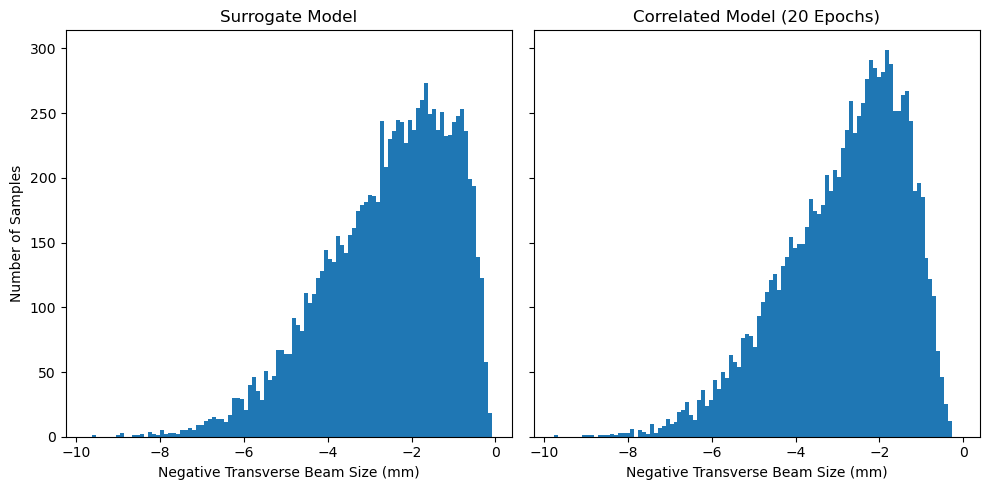

In [7]:
# plot objective distributions
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10, 5))
ax[0].hist(y_test, bins=100)
ax[0].set_title("Surrogate Model")
ax[0].set_ylabel("Number of Samples")
ax[1].hist(y_corr, bins=100)
ax[1].set_title("Correlated Model ({:d} Epochs)".format(idx_best + 1))
for i in range(2):
    ax[i].set_xlabel("{} ({})".format(ground_truth.name, ground_truth.unit))
fig.tight_layout()

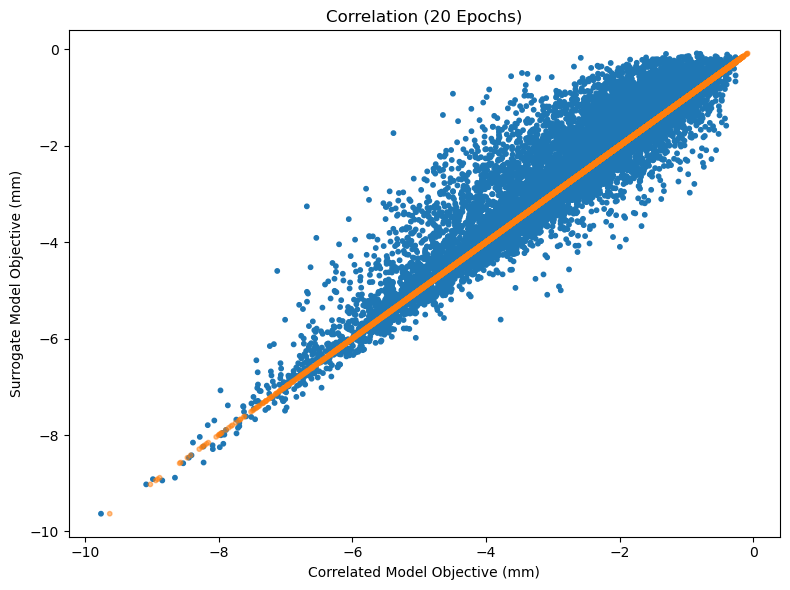

In [8]:
# plot correlations
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.set_xlabel("Correlated Model Objective ({})".format(ground_truth.unit))
ax.set_ylabel("Surrogate Model Objective ({})".format(ground_truth.unit))
ax.set_title("Correlation ({:d} Epochs)".format(idx_best + 1))
if cutoff_value is not None:
    ax.set_xlim([cutoff_value, 0.0])
    ax.set_ylim([cutoff_value, 0.0])
ax.scatter(y_corr, y_test, s=np.full(n_samples, 10))
ax.scatter(y_test, y_test, s=np.full(n_samples, 10), alpha=0.5)
fig.tight_layout()

In [9]:
# use sample optimum as reference point
ref_idx = torch.argmax(y_test)
ref_x, ref_y = x_test[ref_idx], y_test[ref_idx]

def scan_ref_x(n_samples, name):
    idx = input_names.index(name)
    v_lim = vocs.variables[name]
    samples = ref_x.repeat(n_samples, 1)
    samples[:, idx] = torch.linspace(v_lim[0], v_lim[1], n_samples)
    return samples.double()

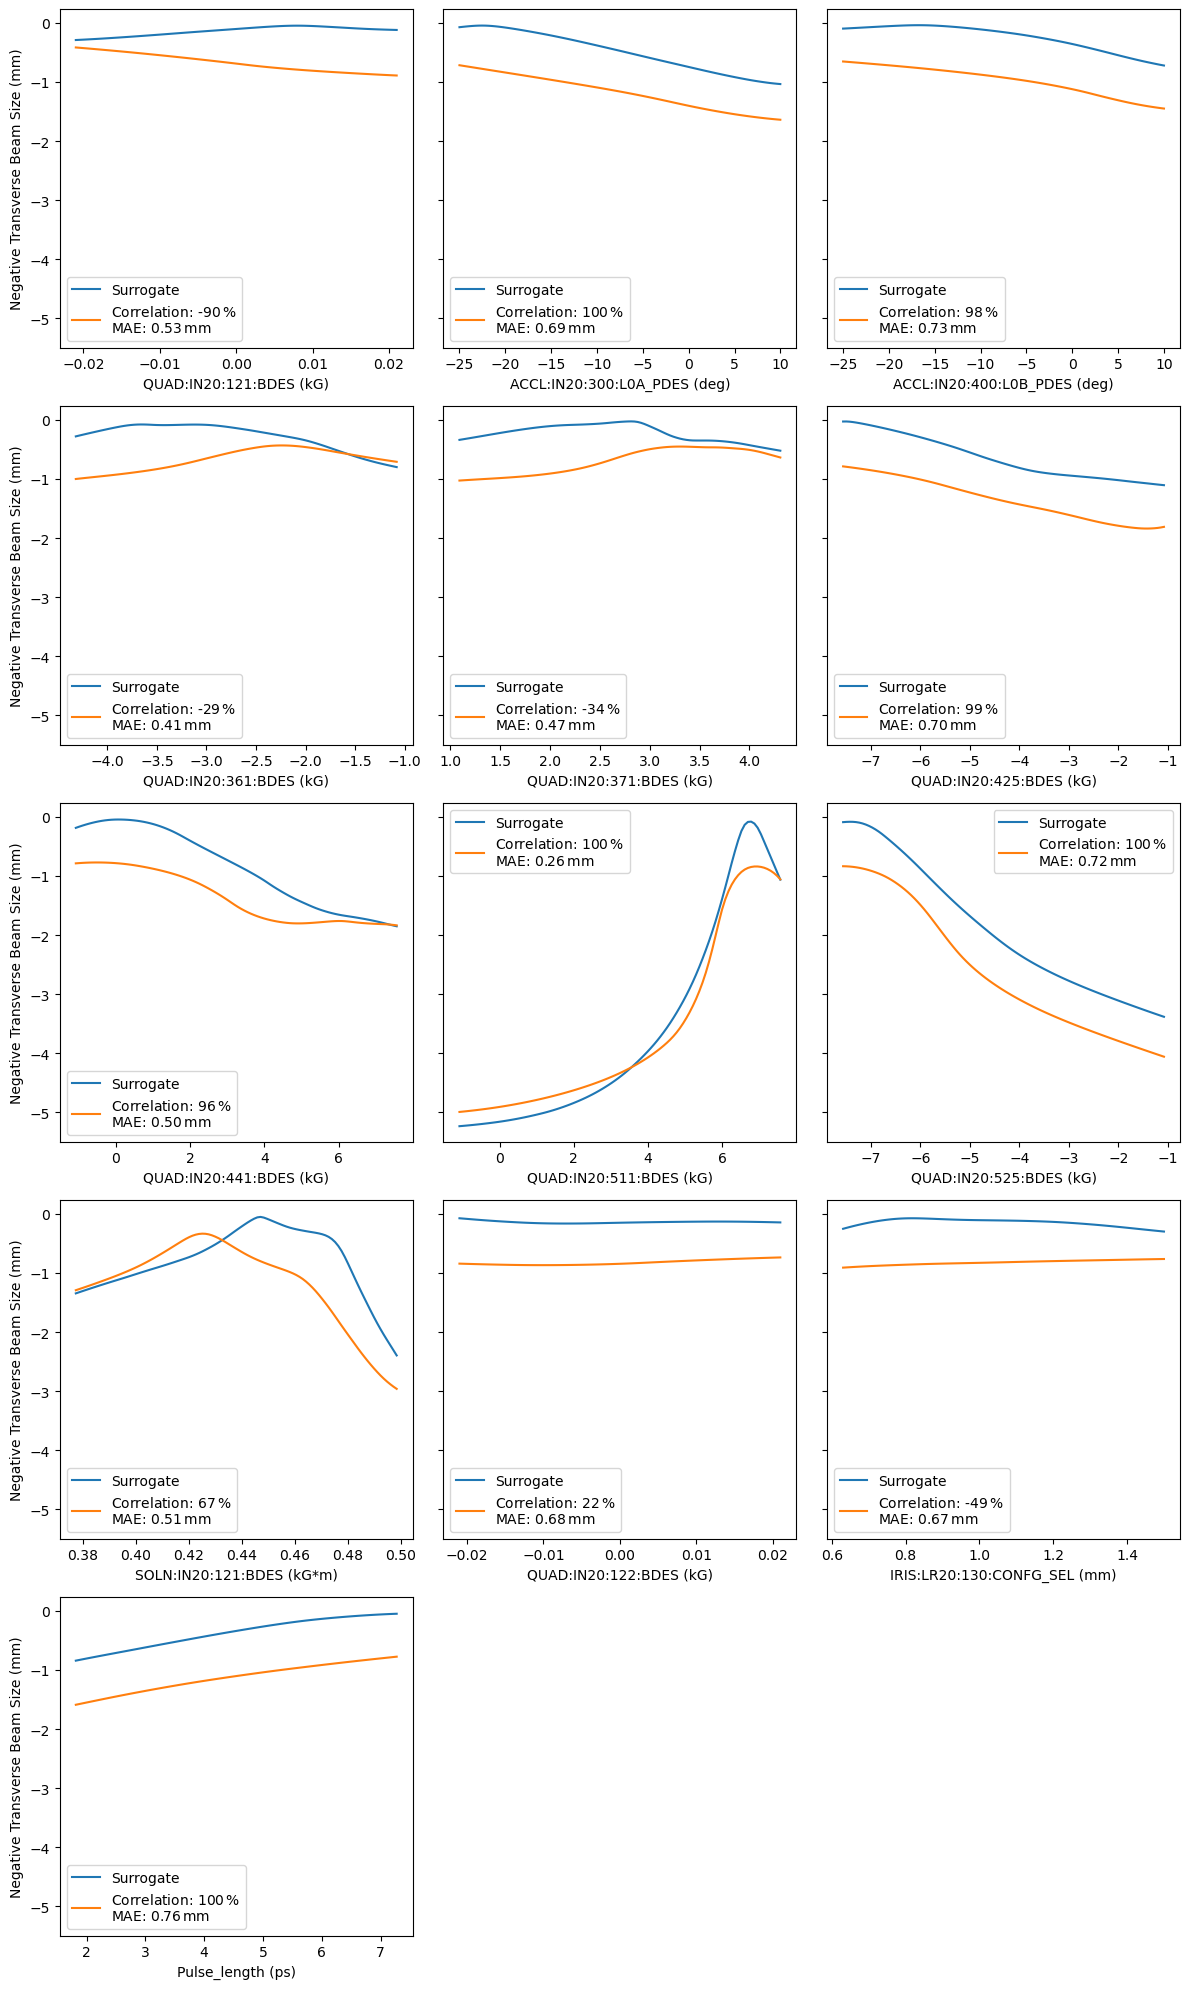

In [10]:
# correlation for individual input dimensions
n_scan = 100
nrows, ncols = 5, 3
figsize = (12, 12 * nrows / ncols)

pv_info = json.load(open("configs/pv_info.json"))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, figsize=figsize)
for i in range(nrows * ncols):
    ax_i = ax[i // ncols, i % ncols]
    if i >= len(vocs.variable_names):
        ax_i.axis('off')
    else:
        name = vocs.variable_names[i]
        # calculate 1D scan
        x_scan = scan_ref_x(n_scan, name=name)
        y_scan = ground_truth(x_scan).detach()
        y_corr_scan = corr_obj(x_scan).detach()
        corr = calc_corr(y_scan, y_corr_scan, cutoff_value)
        mae = calc_mae(y_scan, y_corr_scan, cutoff_value)

        # map sim values to pv
        pv_name = pv_info["sim_name_to_pv_name"][name]
        pv_factor = pv_info["sim_to_pv_factor"][name]
        pv_unit = pv_info["pv_unit"][pv_name]

        # plot data
        idx = input_names.index(name)
        ax_i.plot(x_scan[:, idx] * pv_factor, y_scan, "C0", label="Surrogate")
        ax_i.plot(x_scan[:, idx] * pv_factor, y_corr_scan, "C1", 
                  label="Correlation: {:.0f}$\,$%\nMAE: {:.2f}$\,${}".format(
                      100 * corr, mae, ground_truth.unit))
        ax_i.set_xlabel("{} {}".format(pv_name, pv_unit))
        if i % ncols == 0:
            ax_i.set_ylabel("{} ({})".format(ground_truth.name, ground_truth.unit))
        ax_i.legend()
fig.tight_layout()